In [1]:
%matplotlib inline

In [135]:
import numpy as np
import pandas as pd
from mne.io import RawArray
from mne.channels import read_montage
from mne.epochs import concatenate_epochs
from mne import create_info, find_events, Epochs, concatenate_raws, pick_types
from mne.viz.topomap import _prepare_topo_plot, plot_topomap
from mne.decoding import CSP

from sklearn.linear_model import LogisticRegression
from glob import glob

from scipy.signal import butter, lfilter, convolve, boxcar

In [136]:
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.cross_validation import cross_val_score, LeaveOneLabelOut
from glob import glob

In [5]:
subjects = range(1, 13)

In [6]:
def creat_mne_raw_object(fname,read_events=True):
    """Create a mne raw instance from csv file"""
    
    # Read EEG file
    data = pd.read_csv(fname)
    
    # get chanel names
    ch_names = list(data.columns[1:])
    
    # read EEG standard montage from mne
    montage = read_montage('standard_1005',ch_names)
    
    ch_type = ['eeg']*len(ch_names)
    
    # Scale and transpose data (rows now channels in numpy matrix)
    data = 1e-6*np.array(data[ch_names]).T
    
    if read_events:
        # events file
        ev_fname = fname.replace('_data','_events')
        # read event file
        events = pd.read_csv(ev_fname)
        events_names = events.columns[1:]
        events_data = np.array(events[events_names]).T
        
        # define channel type, the first is EEG, the last 6 are stimulations
        ch_type.extend(['stim']*6)
        ch_names.extend(events_names)
        # concatenate event file and data (vstack)
        data = np.concatenate((data,events_data))
        
        # create and populate MNE info structure
        info = create_info(ch_names,sfreq=500.0, ch_types=ch_type, montage=montage)
        info['filename'] = fname

        # create raw object 
        raw = RawArray(data,info,verbose=False)

        return raw

In [12]:
for subject in subjects:
    fnames = glob('train/subj%d_series*_data.csv' % (subject))
    for fname in fnames:
        #creat_mne_raw_object(fname)
        pass

In [7]:
fname = 'train/subj1_series1_data.csv'

In [8]:
data = pd.read_csv(fname)
#creat_mne_raw_object('train/subj1_series1_data.csv')

In [9]:
data.head()

,id,Fp1,Fp2,F7,F3,Fz,F4,F8,FC5,FC1,...,P7,P3,Pz,P4,P8,PO9,O1,Oz,O2,PO10
0,subj1_series1_0,-31,363,211,121,211,15,717,279,35,...,536,348,383,105,607,289,459,173,120,704
1,subj1_series1_1,-29,342,216,123,222,200,595,329,43,...,529,327,369,78,613,248,409,141,83,737
2,subj1_series1_2,-172,278,105,93,222,511,471,280,12,...,511,319,355,66,606,320,440,141,62,677
3,subj1_series1_3,-272,263,-52,99,208,511,428,261,27,...,521,336,356,71,568,339,437,139,58,592
4,subj1_series1_4,-265,213,-67,99,155,380,476,353,32,...,550,324,346,76,547,343,446,171,67,581


In [10]:
# get chanel names
ch_names = list(data.columns[1:])

In [11]:
montage = read_montage('standard_1005',ch_names)

In [12]:
ch_type = ['eeg']*len(ch_names)

In [13]:
data = 1e-6*np.array(data[ch_names]).T

In [14]:
data.shape

(32, 119496)

In [15]:
# events file
ev_fname = fname.replace('_data','_events')
# read event file
events = pd.read_csv(ev_fname)
events_names = events.columns[1:]
events_data = np.array(events[events_names]).T

In [16]:
data.shape

(32, 119496)

In [17]:
events_data.shape

(6, 119496)

In [18]:
data = np.concatenate((data, events_data))

In [19]:
data.shape

(38, 119496)

In [20]:
ch_type.extend(['stim']*6)
ch_names.extend(events_names)

In [21]:
info = create_info(ch_names, sfreq=500.0, ch_types=ch_type, montage=montage)

In [24]:
info

<Info | 14 non-empty fields
    bads : list | 0 items
    ch_names : list | Fp1, Fp2, F7, F3, Fz, F4, F8, FC5, FC1, FC2
    chs : list | 38 items (EEG: 32, STIM: 6)
    comps : list | 0 items
    custom_ref_applied : bool | False
    dev_head_t : dict | 3 items
    events : list | 0 items
    filename : str | train.../subj1_series1_data.csv
    hpi_meas : list | 0 items
    hpi_results : list | 0 items
    meas_date : numpy.ndarray | 1969-12-31 16:00:00
    nchan : int | 38
    projs : list | 0 items
    sfreq : float | 500.0
    acq_pars : NoneType
    acq_stim : NoneType
    ctf_head_t : NoneType
    description : NoneType
    dev_ctf_t : NoneType
    dig : NoneType
    experimenter : NoneType
    file_id : NoneType
    highpass : NoneType
    hpi_subsystem : NoneType
    line_freq : NoneType
    lowpass : NoneType
    meas_id : NoneType
    proj_id : NoneType
    proj_name : NoneType
    subject_info : NoneType
>

In [23]:
info['filename'] = fname

In [25]:
raw = RawArray(data, info, verbose=False)

In [104]:
raw

<Raw  |  n_channels x n_times : 38 x 119496>

In [26]:
subject = 1

In [27]:
fnames =  glob('train/subj%d_series*_data.csv' % (subject))

In [28]:
raw = concatenate_raws([creat_mne_raw_object(fname) for fname in fnames])

In [29]:
start, stop = raw.time_as_index([0, 2])

In [30]:
data, times = raw[0:len(ch_names)-6, start:stop]

In [31]:
one_raw = creat_mne_raw_object('train/subj1_series1_data.csv')

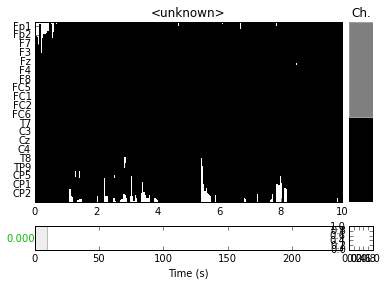

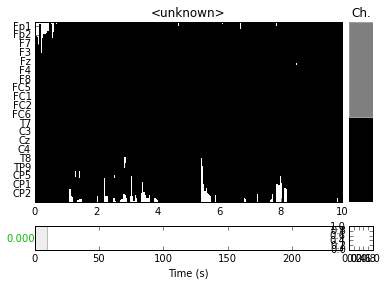

In [32]:
one_raw.plot()

In [33]:
picks = pick_types(raw.info, eeg=True)

In [34]:
picks

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])

In [35]:
stim_cols = pick_types(raw.info,stim=True)

In [36]:
stim_cols

array([32, 33, 34, 35, 36, 37])

In [37]:
raw._data[picks]

array([[ -3.10000000e-05,  -2.90000000e-05,  -1.72000000e-04, ...,
          1.40000000e-04,   1.45000000e-04,   1.44000000e-04],
       [  3.63000000e-04,   3.42000000e-04,   2.78000000e-04, ...,
          3.50000000e-04,   3.23000000e-04,   2.65000000e-04],
       [  2.11000000e-04,   2.16000000e-04,   1.05000000e-04, ...,
          3.71000000e-04,   3.80000000e-04,   4.00000000e-04],
       ..., 
       [  1.73000000e-04,   1.41000000e-04,   1.41000000e-04, ...,
          1.45000000e-04,   1.44000000e-04,   5.90000000e-05],
       [  1.20000000e-04,   8.30000000e-05,   6.20000000e-05, ...,
          2.45000000e-04,   2.79000000e-04,   2.23000000e-04],
       [  7.04000000e-04,   7.37000000e-04,   6.77000000e-04, ...,
          1.63000000e-04,   3.04000000e-04,   2.38000000e-04]])

In [38]:
raw._times

array([  0.00000000e+00,   2.00000000e-03,   4.00000000e-03, ...,
         2.84477800e+03,   2.84478000e+03,   2.84478200e+03])

In [39]:
# design a butterworth bandpass filter 
freqs = [7, 30]
b,a = butter(5,np.array(freqs)/250.0,btype='bandpass')

In [50]:
Fp1 = raw._data[picks][0, :]

In [51]:
Fp1

array([ -3.10000000e-05,  -2.90000000e-05,  -1.72000000e-04, ...,
         1.40000000e-04,   1.45000000e-04,   1.44000000e-04])

In [52]:
montage

<Montage | standard_1005 - 32 Channels: Fp1, Fp2, F7 ...>

In [53]:
Fp1_info = create_info(['Fp1'], sfreq=500.0, ch_types=['eeg'], montage=montage)

In [54]:
Fp1_info

<Info | 13 non-empty fields
    bads : list | 0 items
    ch_names : list | Fp1
    chs : list | 1 items (EEG: 1)
    comps : list | 0 items
    custom_ref_applied : bool | False
    dev_head_t : dict | 3 items
    events : list | 0 items
    hpi_meas : list | 0 items
    hpi_results : list | 0 items
    meas_date : numpy.ndarray | 1969-12-31 16:00:00
    nchan : int | 1
    projs : list | 0 items
    sfreq : float | 500.0
    acq_pars : NoneType
    acq_stim : NoneType
    ctf_head_t : NoneType
    description : NoneType
    dev_ctf_t : NoneType
    dig : NoneType
    experimenter : NoneType
    file_id : NoneType
    filename : NoneType
    highpass : NoneType
    hpi_subsystem : NoneType
    line_freq : NoneType
    lowpass : NoneType
    meas_id : NoneType
    proj_id : NoneType
    proj_name : NoneType
    subject_info : NoneType
>

In [56]:
Fp1.shape

(1422392,)

In [63]:
Fp1 = np.matrix(Fp1)

In [64]:
Fp1.shape

(1, 1422392)

In [67]:
Fp1 = np.array(Fp1)

In [68]:
Fp1_raw = RawArray(Fp1, Fp1_info)

Creating RawArray with float64 data, n_channels=1, n_times=1422392
    Range : 0 ... 1422391 =      0.000 ...  2844.782 secs
Ready.


In [69]:
Fp1_raw
#np.array(Fp1_raw._data)

<Raw  |  n_channels x n_times : 1 x 1422392>

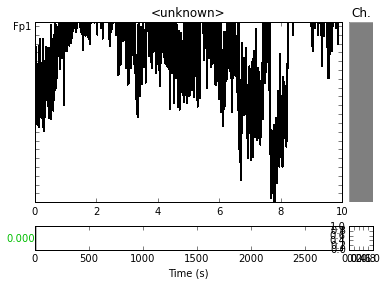

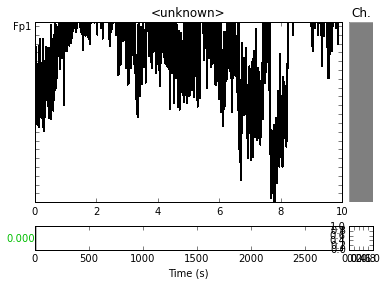

In [70]:
Fp1_raw.plot()

In [71]:
import matplotlib.pyplot as plt

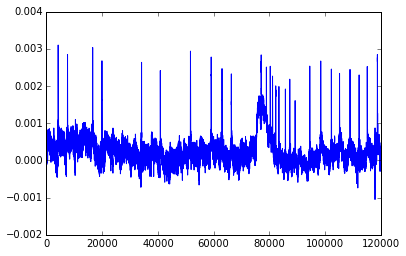

In [72]:
# (Roughly) First scaled series
plt.plot(Fp1_raw._data[0, 0:120000])

In [73]:
Fp1_butterworth = lfilter(b, a, Fp1_raw._data)

In [74]:
Fp1

array([[ -3.10000000e-05,  -2.90000000e-05,  -1.72000000e-04, ...,
          1.40000000e-04,   1.45000000e-04,   1.44000000e-04]])

In [75]:
Fp1_butterworth

array([[ -1.26505967e-09,  -1.24610240e-08,  -6.63332179e-08, ...,
         -9.22087257e-05,  -8.25357969e-05,  -6.16638491e-05]])

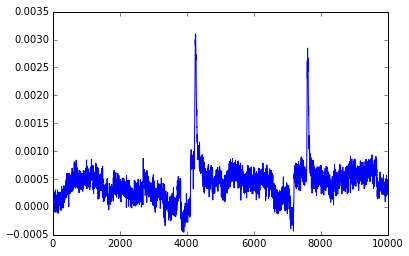

In [76]:
plt.plot(Fp1[0, 0:10000])

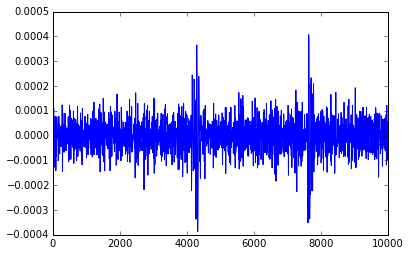

In [77]:
plt.plot(Fp1_butterworth[0, 0:10000])

In [78]:
raw._data[picks] = lfilter(b,a,raw._data[picks])

In [79]:
# get event posision corresponding to Replace
events = find_events(raw,stim_channel='Replace', verbose=False)

In [80]:
epochs_tot = []
y = []

In [81]:
# epochs signal for 1.5 second before the movement
epochs = Epochs(raw, events, {'during' : 1}, -2, -0.5, proj=False, picks=picks, baseline=None, preload=True, add_eeg_ref=False, verbose=False)

In [82]:
replaces = epochs['during'].get_data()

In [83]:
replaces[0]

array([[  3.29789974e-05,   3.53779255e-05,   3.82070942e-05, ...,
         -2.35630657e-05,   2.71848751e-05,   7.52116326e-05],
       [  1.14714298e-04,   1.39889137e-04,   1.55200180e-04, ...,
         -7.01646707e-05,  -5.09550736e-05,  -2.16934223e-05],
       [  1.13518829e-05,   2.52075479e-05,   3.74375932e-05, ...,
          3.92707578e-05,   4.14762101e-05,   4.37154535e-05],
       ..., 
       [  1.39766204e-05,   1.99365993e-05,   2.54147000e-05, ...,
          2.55925285e-05,   4.96753754e-06,  -1.17606596e-05],
       [  6.49840546e-06,   1.16984147e-05,   1.60815926e-05, ...,
          2.54726225e-05,   5.41291599e-06,  -1.13886045e-05],
       [  1.20623427e-05,   1.16607016e-05,   1.07886151e-05, ...,
          3.43245938e-05,   8.01807353e-06,  -1.53814210e-05]])

In [84]:
epochs_tot.append(epochs)

In [85]:
# put epochs in list
epochs_tot

[<Epochs  |  n_events : 260 (all good), tmin : -2 (s), tmax : -0.5 (s), baseline : None>]

In [86]:
y.extend([1]*len(epochs))

In [87]:
# epochs signal for 1.5 second after the movement, this correspond to the 
# rest period.
epochs_rest = Epochs(raw, events, {'after' : 1}, 0.5, 2, proj=False, picks=picks, baseline=None, preload=True, add_eeg_ref=False, verbose=False)

In [88]:
rests = epochs_rest.get_data()

In [89]:
rests.shape

(259, 32, 751)

In [90]:
rests[0]

array([[  9.70429426e-06,  -1.56120812e-05,  -4.44617548e-05, ...,
          4.82181606e-05,   5.82282274e-05,   6.06845722e-05],
       [  7.65125326e-05,   2.40457635e-05,  -3.44390797e-05, ...,
         -2.03622110e-05,   1.40754345e-05,   4.59410253e-05],
       [ -4.54275770e-05,  -6.88849699e-05,  -9.18092390e-05, ...,
         -4.79045560e-05,  -4.98959643e-05,  -4.81605171e-05],
       ..., 
       [  2.01798132e-05,   1.92230062e-05,   1.88584926e-05, ...,
         -6.49696692e-05,  -7.18478454e-05,  -7.82293491e-05],
       [  3.07552633e-05,   2.77301666e-05,   2.46201412e-05, ...,
         -5.18921428e-05,  -5.92161752e-05,  -6.61740285e-05],
       [  5.22452772e-05,   3.64871349e-05,   1.91404693e-05, ...,
         -2.46714849e-05,  -3.27829953e-05,  -4.03699667e-05]])

In [91]:
# Workaround to be able to concatenate epochs with MNE
epochs_rest.times = epochs.times

In [92]:
y.extend([-1]*len(epochs_rest))

In [93]:
epochs_tot.append(epochs_rest)

In [94]:
# Concatenate all epochs
epochs = concatenate_epochs(epochs_tot)

In [95]:
epochs[400]

<Epochs  |  n_events : 1 (all good), tmin : -2.0 (s), tmax : -0.5 (s), baseline : None,
 'after': 1, 'during': 1>

In [96]:
# get data 
X = epochs.get_data()
y = np.array(y)

In [97]:
X.shape

(519, 32, 751)

In [98]:
print X[259]
print y[259]

[[  2.92630196e-05   2.80513011e-05   2.35843446e-05 ...,   3.62440342e-05
    4.22582614e-05   4.82953875e-05]
 [ -1.67845465e-05  -1.76621130e-05  -1.62228310e-05 ...,  -2.54675149e-05
   -2.24079113e-05  -1.62495741e-05]
 [  1.27703696e-05   2.82485945e-06  -7.57463705e-06 ...,  -3.26957907e-06
   -1.46607988e-05  -2.48010719e-05]
 ..., 
 [ -2.28811603e-05  -1.89541984e-05  -8.30815448e-06 ...,  -7.10357324e-05
   -7.55775472e-05  -7.37290949e-05]
 [  2.53277036e-05   2.39778790e-05   2.51553809e-05 ...,  -6.20161396e-05
   -6.60894720e-05  -6.39617924e-05]
 [  5.83009172e-05   5.90149903e-05   5.78606885e-05 ...,  -1.17363058e-04
   -1.15856880e-04  -1.06012314e-04]]
1


In [99]:
print X[260]
print y[260]

[[  9.70429426e-06  -1.56120812e-05  -4.44617548e-05 ...,   4.82181606e-05
    5.82282274e-05   6.06845722e-05]
 [  7.65125326e-05   2.40457635e-05  -3.44390797e-05 ...,  -2.03622110e-05
    1.40754345e-05   4.59410253e-05]
 [ -4.54275770e-05  -6.88849699e-05  -9.18092390e-05 ...,  -4.79045560e-05
   -4.98959643e-05  -4.81605171e-05]
 ..., 
 [  2.01798132e-05   1.92230062e-05   1.88584926e-05 ...,  -6.49696692e-05
   -7.18478454e-05  -7.82293491e-05]
 [  3.07552633e-05   2.77301666e-05   2.46201412e-05 ...,  -5.18921428e-05
   -5.92161752e-05  -6.61740285e-05]
 [  5.22452772e-05   3.64871349e-05   1.91404693e-05 ...,  -2.46714849e-05
   -3.27829953e-05  -4.03699667e-05]]
-1


In [100]:
# CSP parameters
# Number of spatial filter to use
nfilters = 4

In [101]:
# Train CSP. Use Ledoit-Wolf Shrinkage for regularization
csp = CSP(n_components=nfilters, reg='lws')
csp.fit(X,y)

In [120]:
csp.filters_[0, :].T

array([  1.42841584e-01,  -1.24476011e-02,  -1.15181086e+00,
        -4.81122274e-01,   2.17852531e+00,  -1.78174471e-01,
        -1.85794243e-01,  -2.47393150e+00,  -1.06285101e+01,
         4.05632791e-01,  -1.95090674e-01,   1.36002630e+00,
         2.93879680e+01,  -8.57205448e+00,   1.14897067e+00,
        -3.49279721e-02,  -1.19594992e+00,  -5.65571685e+00,
        -9.30714813e-01,  -9.08427002e-01,   2.96800092e-01,
        -1.14316385e-01,   8.49736442e-02,  -2.57584082e+00,
        -2.34278313e+00,   1.88698035e+00,  -1.01862718e+00,
        -6.48087281e-02,   6.28525769e-01,  -3.28485770e-01,
         2.76338945e-01,   2.10768383e-01])

In [125]:
from scipy.signal import welch

In [130]:
X.shape

(519, 32, 751)

In [127]:
po = []
for x in X:
    f,p = welch(np.dot(csp.filters_[0,:].T,x), 500, nperseg=512)
    po.append(p)
po = np.array(po)    

In [137]:
# prepare topoplot
_,epos,_,_,_ = _prepare_topo_plot(epochs,'eeg',None)

In [138]:
_prepare_topo_plot?

In [140]:
# plot first pattern
pattern = csp.patterns_[0,:]
pattern -= pattern.mean()
ix = np.argmax(abs(pattern))
# the parttern is sign invariant.
# invert it for display purpose
if pattern[ix]>0:
    sign = 1.0
else:
    sign = -1.0

In [142]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

<matplotlib.colorbar.Colorbar instance at 0x109c21440>

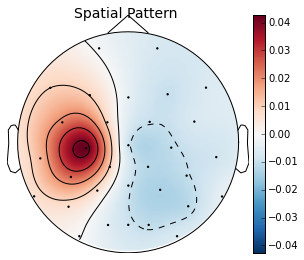

In [143]:
fig, ax_topo = plt.subplots(1, 1, figsize=(12, 4))
title = 'Spatial Pattern'
fig.suptitle(title, fontsize=14)
img, _ = plot_topomap(sign*pattern,epos,axis=ax_topo,show=False)
divider = make_axes_locatable(ax_topo)
# add axes for colorbar
ax_colorbar = divider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(img, cax=ax_colorbar)

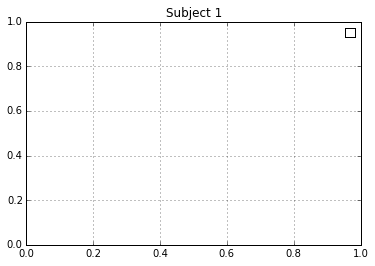

In [145]:
# plot spectrum
fix = (f>7) & (f<35)
ax_spectrum = divider.append_axes('right', size='300%', pad=1.2)
ax_spectrum.plot(f[fix],np.log(po[y==1][:,fix].mean(axis=0).T),'-r',lw=2)
ax_spectrum.plot(f[fix],np.log(po[y==-1][:,fix].mean(axis=0).T),'-b',lw=2)
ax_spectrum.set_xlabel('Frequency (Hz)')
ax_spectrum.set_ylabel('Power (dB)')
plt.grid()
plt.legend(['during','after'])
plt.title('Subject %d' % subject)
plt.show()

In [146]:
f[fix]

array([  7.8125   ,   8.7890625,   9.765625 ,  10.7421875,  11.71875  ,
        12.6953125,  13.671875 ,  14.6484375,  15.625    ,  16.6015625,
        17.578125 ,  18.5546875,  19.53125  ,  20.5078125,  21.484375 ,
        22.4609375,  23.4375   ,  24.4140625,  25.390625 ,  26.3671875,
        27.34375  ,  28.3203125,  29.296875 ,  30.2734375,  31.25     ,
        32.2265625,  33.203125 ,  34.1796875])

In [147]:
np.log(po[y==1][:,fix].mean(axis=0).T)

array([-19.34422328, -19.40080235, -19.4824106 , -19.66696077,
       -19.7637253 , -19.83058866, -19.94068202, -19.92106442,
       -20.0754226 , -20.02276747, -19.95148003, -19.91842961,
       -19.809203  , -19.82470918, -20.09594484, -20.1539438 ,
       -20.09419331, -20.07571759, -20.24471124, -20.30963315,
       -20.21035566, -20.36936151, -20.59445868, -20.9025393 ,
       -21.25086302, -21.67973261, -22.06481963, -22.51374219])

In [149]:
make_pipeline?